# Building a Solar Panel Detector
<!-- 
Author: Shardul Junagade

Date: 27 February 2025 -->

In this notebook, we will build a solar panel detector that can detect solar panels in aerial images. We'll use the YOLOv12 model, which is the latest state-of-the-art object detection model from Ultralytics, to identify and locate solar panels in high-resolution aerial imagery.

This project will demonstrate:

- Data preprocessing and exploration of the Solar Panel Object Labels dataset
- Implementation of evaluation metrics (IoU, AP)
- Training and fine-tuning of the YOLOv12 model
- Evaluation of model performance on test data
- Visualization and interpretation of results

### Importing Libraries

In [2]:
import torch
from ultralytics import YOLO
import supervision as sv
import shapely.geometry as sg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

# Retina display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Data Exploration and Understanding

We will use the [Solar Panel Object Labels dataset from Figshare](https://figshare.com/articles/dataset/Solar_Panel_Object_Labels/22081091). This dataset contains high-resolution aerial images with labeled solar panels. We will use the 31 cm native resolution images of sizes 416x416 pixels for our analysis.

The dataset files follow a specific naming structure: `solarpanels_native_<image_number>__x0_<x_coordinate>_y0_<y_coordinate>_dxdy_<size>`.

For example, in the file `solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt`:

- `solarpanels_native`: Indicates that the file contains solar panel data in native resolution.
- `<image_number>`: The number of the image in the dataset.
- `x0_<x_coordinate>`: The x-coordinate of the top-left corner of the image.
- `y0_<y_coordinate>`: The y-coordinate of the top-left corner of the image.
- `dxdy_<size>`: The size of the image in pixels (both width and height).

Each line in the file represents a detected solar panel with the following format: `category x_center y_center width height`, where:

- `category`: The category label (0 for solar panels).
- `x_center`: The x-coordinate of the center of the bounding box (normalized).
- `y_center`: The y-coordinate of the center of the bounding box (normalized).
- `width`: The width of the bounding box (normalized).
- `height`: The height of the bounding box (normalized).


In [3]:
image_dir = 'data/images_native/'
label_dir = 'data/labels_native/'
image_size = 416
meters_per_pixel = 0.31  # meters per pixel

In [ ]:
image_names = sorted([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.tif')])
label_names = sorted([label_name for label_name in os.listdir(label_dir) if label_name.endswith('.txt')])

print('Number of images:', len(image_names))
print('Number of labels:', len(label_names))

Number of images: 2553
Number of labels: 2542


The number of images and the number of labels is not the same. So, we can remove the images that do not have corresponding labels and remove the labels that do not have corresponding images.

In [5]:
# delete the images that do not have corresponding labels
for image_name in image_names:
    if image_name.replace('.tif', '.txt') not in label_names:
        os.remove(image_dir + image_name)

# delete the labels that do not have corresponding images
for label_name in label_names:
    if label_name.replace('.txt', '.tif') not in image_names:
        os.remove(label_dir + label_name)

image_names = sorted([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.tif')])
label_names = sorted([label_name for label_name in os.listdir(label_dir) if label_name.endswith('.txt')])

print('Number of images:', len(image_names))
print('Number of labels:', len(label_names))

Number of images: 2542
Number of labels: 2542


### Dataset Statistics

In [ ]:
total_instances = 0
class_count = {}

for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)

    with open(label_path, 'r') as f:
        lines = f.readlines()
        total_instances += len(lines)
        for line in lines:
            class_name = line.split()[0]
            class_count[class_name] = class_count.get(class_name, 0) + 1

class_count = dict(sorted(class_count.items()))

print('Total instances:', total_instances)
print('\nNumber of unique classes:', len(class_count))
print('\nClass-wise distribution:')
for class_name, count in class_count.items():
    print(f'    Class {class_name}: {count}')

Total instances: 29625

Number of unique classes: 3

Class-wise distribution:
    Class 0: 29267
    Class 1: 130
    Class 2: 228


Since, we are doing a detection task, I converted all labels of class 1 and 2 to class 0.

In [7]:
# convert all classes to 0 in the labels
for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)
    with open(label_path, 'r') as f:
        lines = f.readlines()
    with open(label_path, 'w') as f:
        for line in lines:
            f.write('0 ' + ' '.join(line.split()[1:]) + '\n')

# updated class count
class_count = {}
for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_name = line.split()[0]
            class_count[class_name] = class_count.get(class_name, 0) + 1
print('Updated class-wise distribution:')
for class_name, count in class_count.items():
    print(f'    Class {class_name}: {count}')

Updated class-wise distribution:
    Class 0: 29625


In [8]:
# Calculate number of images having a particular number of labels
label_distribution = {}
for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        num_labels = len(lines)
        label_distribution[num_labels] = label_distribution.get(num_labels, 0) + 1

label_distribution = dict(sorted(label_distribution.items()))
print('Value counts of labels per image:')
for num_labels, count in label_distribution.items():
    print(f'{count} images have {num_labels} labels.')

Value counts of labels per image:
81 images have 1 labels.
167 images have 2 labels.
221 images have 3 labels.
218 images have 4 labels.
217 images have 5 labels.
189 images have 6 labels.
170 images have 7 labels.
184 images have 8 labels.
169 images have 9 labels.
121 images have 10 labels.
97 images have 11 labels.
84 images have 12 labels.
69 images have 13 labels.
49 images have 14 labels.
46 images have 15 labels.
41 images have 16 labels.
36 images have 17 labels.
25 images have 18 labels.
29 images have 19 labels.
14 images have 20 labels.
4 images have 21 labels.
1 images have 22 labels.
4 images have 23 labels.
2 images have 24 labels.
4 images have 25 labels.
3 images have 26 labels.
5 images have 27 labels.
5 images have 28 labels.
15 images have 29 labels.
20 images have 30 labels.
8 images have 31 labels.
7 images have 32 labels.
13 images have 33 labels.
19 images have 34 labels.
10 images have 35 labels.
6 images have 36 labels.
17 images have 37 labels.
13 images have 

### Area of Solar Panels

We can calculate the area of the solar panels (in square meters) as follows:

1. **Denormalize x-width and y-width:**
    - Multiply by the chip size:
      - Native resolution (31 cm): $416 \times 416$
      - HD resolution (15.5 cm): $832 \times 832$

2. **Convert to real-world meters:**
    - Pixel size = 0.31 meters per pixel
    - Real width & height in meters:
      $$
      \text{real\_width} = x\_width \times 416 \times 0.31
      $$
      $$
      \text{real\_height} = y\_width \times 416 \times 0.31
      $$

3. **Compute area:**
    $$
    \text{area} = \text{real\_width} \times \text{real\_height}
    $$



Mean area of solar panels: 191.52 m^2
Standard deviation of area of solar panels: 630.70 m^2


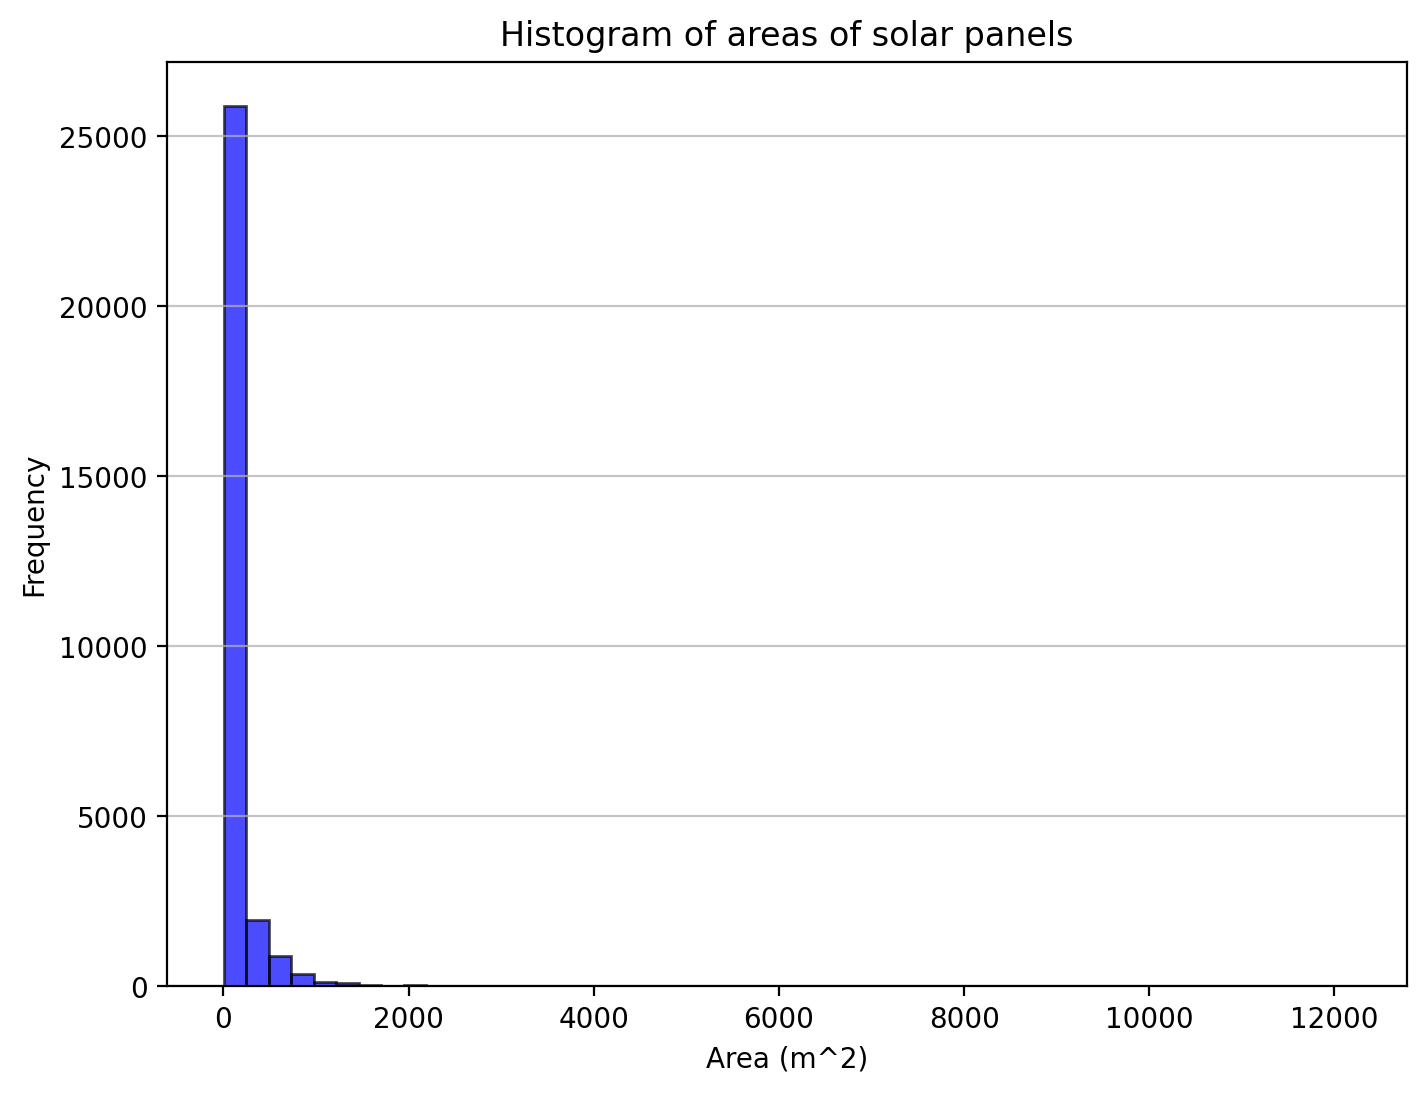

In [9]:
areas = []
for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_name, x_center, y_center, width, height = map(float, line.split())
            # print(class_name, x_center, y_center, width, height)
            real_width = width * image_size * meters_per_pixel
            real_height = height * image_size * meters_per_pixel
            area = real_width * real_height
            areas.append(area)

areas = np.array(areas)
mean_area = np.mean(areas)
std_area = np.std(areas)
print(f'Mean area of solar panels: {mean_area:.2f} m^2')
print(f'Standard deviation of area of solar panels: {std_area:.2f} m^2')

plt.figure(figsize=(8, 6))
plt.hist(areas, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Area (m^2)')
plt.ylabel('Frequency')
plt.title('Histogram of areas of solar panels')
plt.grid(axis='y', alpha=0.75)
plt.show()

From the above histogram, we can observe the following:

- The majority of the solar panels have areas concentrated around the lower end of the scale.
- There are fewer instances of solar panels with larger areas.
- The distribution appears to be right-skewed, indicating that most solar panels are relatively small in size, with a few larger ones.

## Implementing the Fundamental Functions

### Intersection over Union (IoU)

Intersection over Union (IoU) is a metric used to evaluate the accuracy of an object detector on a particular dataset. It measures the overlap between two bounding boxes: the predicted bounding box and the ground truth bounding box.

The IoU is calculated as follows:

1. **Intersection**: The area of overlap between the predicted bounding box and the ground truth bounding box.
2. **Union**: The total area covered by both the predicted bounding box and the ground truth bounding box.

The IoU is then computed as the ratio of the intersection area to the union area:

$$
\text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}}
$$

The IoU value ranges from 0 to 1, where:

- 0 indicates no overlap between the bounding boxes.
- 1 indicates a perfect overlap between the bounding boxes.

**Usage of Shapely Library:**

Shapely's `Polygon` class is used to represent bounding boxes as geometric shapes, defined by their corner coordinates. The intersection area between two polygons is computed using the `.intersection()` method, which finds the overlapping region of the two bounding boxes. The union area is determined using the `.union()` method, which combines both polygons into a single shape.


In [10]:
# convert yolo format to x_min, y_min, x_max, y_max format
def yolo_to_xyxy(yolo_bbox, image_size):
    if len(yolo_bbox) == 5:
        class_id, x_center, y_center, width, height = yolo_bbox
    else:
        x_center, y_center, width, height = yolo_bbox
    x_min = (x_center - width / 2) * image_size
    y_min = (y_center - height / 2) * image_size
    x_max = (x_center + width / 2) * image_size
    y_max = (y_center + height / 2) * image_size
    return x_min, y_min, x_max, y_max

# calculate iou using shapely
def iou_shapely(yolo_bbox1, yolo_bbox2, image_size):
    x_min1, y_min1, x_max1, y_max1 = yolo_to_xyxy(yolo_bbox1, image_size)
    x_min2, y_min2, x_max2, y_max2 = yolo_to_xyxy(yolo_bbox2, image_size)

    polygon1 = sg.Polygon([(x_min1, y_min1), (x_max1, y_min1), (x_max1, y_max1), (x_min1, y_max1)])
    polygon2 = sg.Polygon([(x_min2, y_min2), (x_max2, y_min2), (x_max2, y_max2), (x_min2, y_max2)])

    intersection_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area

    if union_area == 0.0:
        iou = 0.0
    else:
        iou = intersection_area / union_area
    return iou

# calculate iou using supervision
def iou_supervision(yolo_bbox1, yolo_bbox2, image_size):
    box1 = np.array([yolo_to_xyxy(yolo_bbox1, image_size)])
    box2 = np.array([yolo_to_xyxy(yolo_bbox2, image_size)])
    iou_matrix = sv.box_iou_batch(box1, box2)
    return iou_matrix[0, 0]


In [11]:
# Example usage on YOLO bounding boxes (class_id, x_center, y_center, width, height) 
yolo_bbox1 = [0, 0.1, 0.1, 0.6, 0.6]
yolo_bbox2 = [0, 0.3, 0.3, 0.6, 0.6]

iou1 = iou_shapely(yolo_bbox1, yolo_bbox2, image_size)
iou2 = iou_supervision(yolo_bbox1, yolo_bbox2, image_size)

print(f'IoU computed using shapely: {iou1:.4f}')
print(f'IoU computed using supervision: {iou2:.4f}')

IoU computed using shapely: 0.2857
IoU computed using supervision: 0.2857


### Average Precision (AP)

Average Precision (AP) is a metric used to evaluate the performance of object detection models. It summarizes the precision-recall curve into a single value, representing the average of precision values at different recall levels.

- **Precision**: The ratio of true positive detections to the total number of positive detections (true positives + false positives).
  
  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

- **Recall**: The ratio of true positive detections to the total number of actual positives (true positives + false negatives).
  
  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

The precision-recall curve is plotted with precision on the y-axis and recall on the x-axis. The Average Precision (AP) is calculated as the area under the precision-recall curve.

There are different methods to compute AP:

1. **Pascal VOC 11-point interpolation**: Precision is sampled at 11 recall levels (0.0, 0.1, ..., 1.0), and the average of these precision values is taken.
2. **COCO 101-point interpolation**: Precision is sampled at 101 recall levels (0.0, 0.01, ..., 1.0), and the average of these precision values is taken.
3. **Area under Precision-Recall Curve (PRC)**: The area under the precision-recall curve is computed using numerical integration methods.




In [12]:
from sklearn.metrics import auc

def compute_ap(precisions, recalls, method="voc11"):
    # Pascal VOC 11-point method
    if method == "voc11":
        recall_points = np.linspace(0, 1, 11)
        ap = 0.0
        for r in recall_points:
            ap += max(precisions[recalls >= r]) if np.any(recalls >= r) else 0
        ap /= 11
    # COCO 101-point method
    elif method == "coco101":
        recall_points = np.linspace(0, 1, 101)
        ap = np.mean([max(precisions[recalls >= r]) if np.any(recalls >= r) else 0 for r in recall_points])
    # AUC method
    elif method == "auc_pr":
        ap = auc(recalls, precisions)
    else:
        raise ValueError("Invalid AP computation method.")
    return ap


# calculate precision and recall values
def compute_precision_recall(gt_boxes, pred_boxes, scores, image_size, iou_threshold=0.5):
    all_tp = []
    all_fp = []
    num_gt_boxes = sum(len(gt) for gt in gt_boxes)
    if num_gt_boxes == 0:
        return np.array([]), np.array([])

    for gt_boxes_image, pred_boxes_image, scores_image in zip(gt_boxes, pred_boxes, scores):
        # Sort predicted boxes by confidence score in descending order
        sorted_indices = np.argsort(scores_image)[::-1]
        pred_boxes_image = [pred_boxes_image[idx] for idx in sorted_indices]
        scores_image = [scores_image[idx] for idx in sorted_indices]

        tp = np.zeros(len(pred_boxes_image))
        fp = np.zeros(len(pred_boxes_image))
        gt_matched = np.zeros(len(gt_boxes_image))

        for j, pred_box in enumerate(pred_boxes_image):
            if len(gt_boxes_image) == 0:
                fp[j] = 1
                continue
            
            ious = [iou_shapely(pred_box, gt_box, image_size) for gt_box in gt_boxes_image]
            max_iou = max(ious) if ious else 0
            max_iou_idx = np.argmax(ious) if ious else -1

            if max_iou >= iou_threshold and max_iou_idx != -1 and gt_matched[max_iou_idx] == 0:
                tp[j] = 1
                gt_matched[max_iou_idx] = 1
            else:
                fp[j] = 1

        all_tp.extend(tp)
        all_fp.extend(fp)

    # Compute Precision-Recall
    tp_cumsum = np.cumsum(all_tp)
    fp_cumsum = np.cumsum(all_fp)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)  # Avoid division by zero
    recalls = tp_cumsum / num_gt_boxes

    return precisions, recalls

### Comparing AP50s on randomly generated data

In [13]:
# generate random data
def generate_random_data(num_images, image_size, num_gt_boxes, num_pred_boxes, box_size):
    images = []
    gt_boxes = []
    pred_boxes = []
    scores = []

    for _ in range(num_images):
        image = np.random.rand(image_size, image_size)
        images.append(image)

        gt_boxes_image = []
        for _ in range(num_gt_boxes):
            x_min = np.random.randint(0, image_size - box_size)
            y_min = np.random.randint(0, image_size - box_size)
            x_max = x_min + box_size
            y_max = y_min + box_size
            gt_boxes_image.append([x_min, y_min, x_max, y_max])
        gt_boxes.append(gt_boxes_image)

        pred_boxes_image = []
        scores_image = []
        for _ in range(num_pred_boxes):
            x_min = np.random.randint(0, image_size - box_size)
            y_min = np.random.randint(0, image_size - box_size)
            x_max = x_min + box_size
            y_max = y_min + box_size
            pred_boxes_image.append([x_min, y_min, x_max, y_max])
            scores_image.append(np.random.uniform(0.5, 1.0))
        pred_boxes.append(pred_boxes_image)
        scores.append(scores_image)

    return images, gt_boxes, pred_boxes, scores

In [14]:
random_num_images = 10
random_image_size = 100
random_num_gt_boxes = 10
random_num_pred_boxes = 10
random_box_size = 20
random_images, random_gt_boxes, random_pred_boxes, random_scores = generate_random_data(random_num_images, random_image_size, random_num_gt_boxes, random_num_pred_boxes, random_box_size)

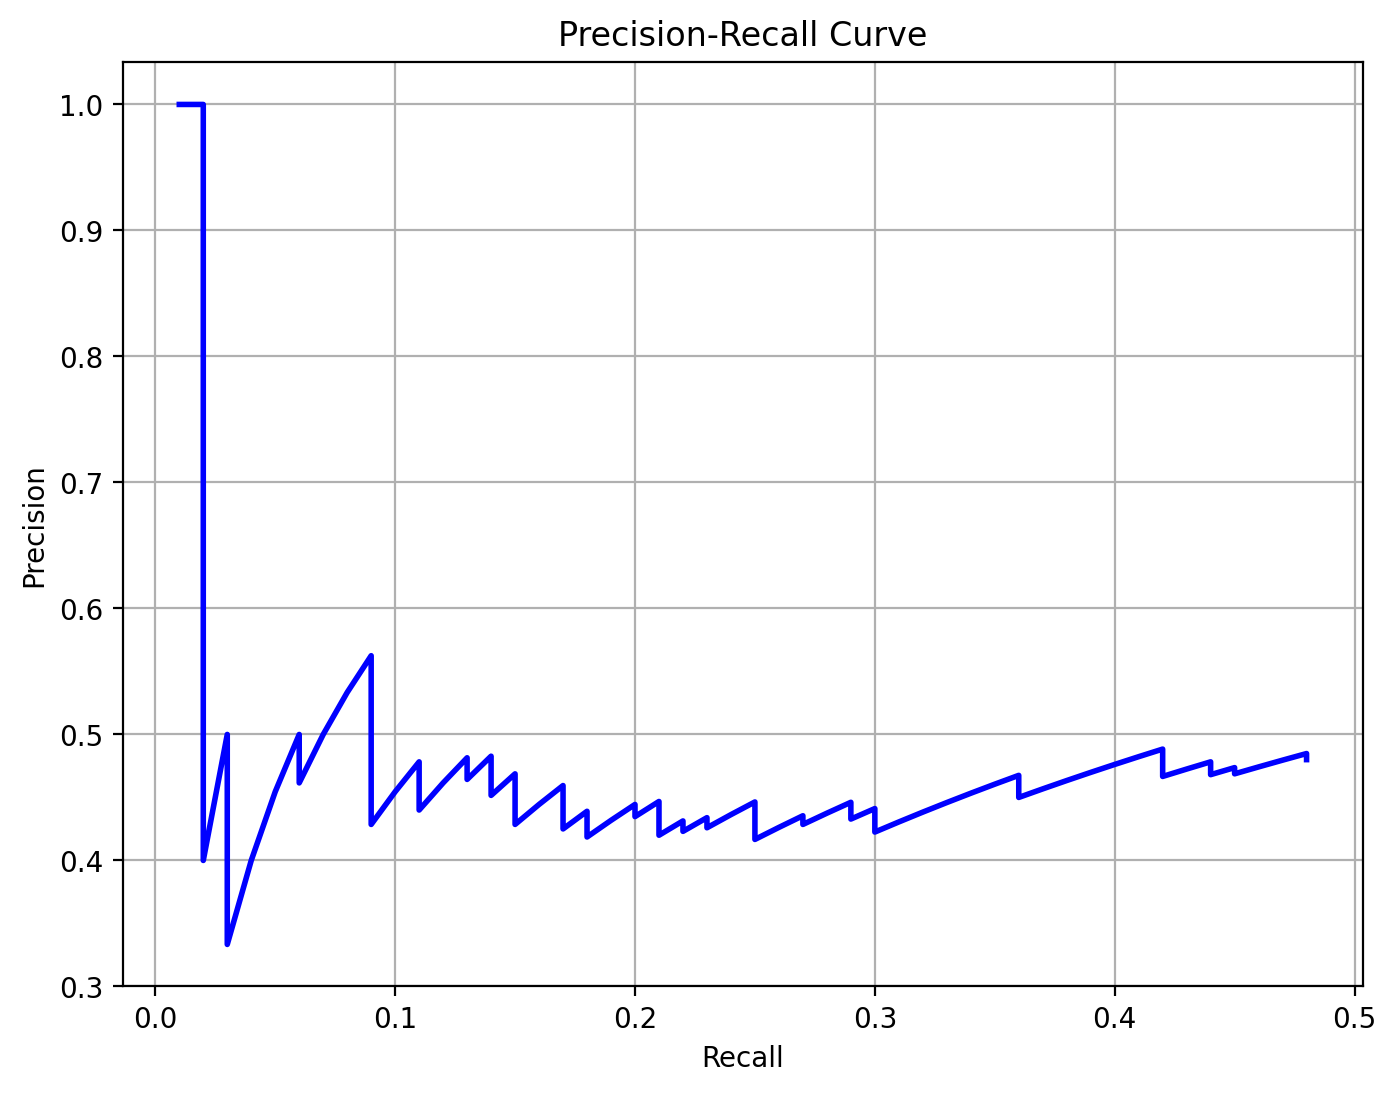

In [15]:
precisions, recalls = compute_precision_recall(random_gt_boxes, random_pred_boxes, random_scores, random_image_size, iou_threshold=0.5)

# plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='blue', linestyle='-', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [16]:
# Compute AP50
ap50_voc11 = compute_ap(precisions, recalls, method="voc11")
ap50_coco101 = compute_ap(precisions, recalls, method="coco101")
ap50_auc_pr = compute_ap(precisions, recalls, method="auc_pr")

print(f'AP50 using VOC11 method: {ap50_voc11:.4f}')
print(f'AP50 using COCO101 method: {ap50_coco101:.4f}')
print(f'AP50 using AUC-PR method: {ap50_auc_pr:.4f}')

AP50 using VOC11 method: 0.2685
AP50 using COCO101 method: 0.2571
AP50 using AUC-PR method: 0.2188


## Model Building and Evaluation

### Splitting the Data

We will split the data into training and testing sets using an 80-20 split. We will further split the training data into training and validation sets using a 90-10 split. This will allow us to train the model on the training set and tune the hyperparameters on the validation set. The testing set will be used to evaluate the model's performance on unseen data.

In [17]:
image_dir = 'data/images_native/'
label_dir = 'data/labels_native/'
image_size = 416
meters_per_pixel = 0.31  # meters per pixel

In [ ]:
def split_data(image_dir, label_dir, save_dir="split_data", train_ratio=0.8, val_ratio=0.1):
    os.makedirs(save_dir, exist_ok=True)
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(save_dir, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(save_dir, split, "labels"), exist_ok=True)
    
    image_names = sorted([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.tif')])
    label_names = sorted([label_name for label_name in os.listdir(label_dir) if label_name.endswith('.txt')])
    num_images = len(image_names)

    # shuffle the data
    indices = np.arange(num_images)
    np.random.shuffle(indices)

    train_size = int(train_ratio * num_images)
    val_size = int(val_ratio * train_size)
    test_size = num_images - train_size

    train_indices = indices[:train_size]
    val_indices = train_indices[-val_size:]
    train_indices = train_indices[:-val_size]
    test_indices = indices[train_size:]

    def copy_data(indices, split):
        for idx in indices:
            image_src = os.path.join(image_dir, image_names[idx])
            label_src = os.path.join(label_dir, label_names[idx])

            image_dst = os.path.join(save_dir, split, "images", image_names[idx])
            label_dst = os.path.join(save_dir, split, "labels", label_names[idx])

            shutil.copy(image_src, image_dst)
            shutil.copy(label_src, label_dst)

    copy_data(train_indices, "train")
    copy_data(val_indices, "val")
    copy_data(test_indices, "test")

    print(f"Data split and saved in '{save_dir}/' successfully!")
    print(f"Train:      {len(train_indices)} images")
    print(f"Validation: {len(val_indices)} images")
    print(f"Test:       {len(test_indices)} images")



split_data(image_dir, label_dir, save_dir="split_data", train_ratio=0.8, val_ratio=0.1)

Data split and saved in 'split_data/' successfully!
Train:      1830 images
Validation: 203 images
Test:       509 images


In [18]:
# Create YAML content with absolute paths
base_path = os.path.abspath('./split_data')
yaml_content = f"""path: {base_path}
train: {os.path.join(base_path, 'train', 'images')}
val: {os.path.join(base_path, 'val', 'images')}
test: {os.path.join(base_path, 'test', 'images')}

nc: 1  # number of classes
names: ['solar_panel']  # class names
"""
data_yml_path = os.path.join(base_path, 'data.yaml')
with open(data_yml_path, 'w') as f:
    f.write(yaml_content)
print(f"data.yaml created at:\n{data_yml_path}")
del base_path

data.yaml created at:
c:\Users\shard\Desktop\SRIP-Project-Task\split_data\data.yaml


In [19]:
print(yaml_content)

path: c:\Users\shard\Desktop\SRIP-Project-Task\split_data
train: c:\Users\shard\Desktop\SRIP-Project-Task\split_data\train\images
val: c:\Users\shard\Desktop\SRIP-Project-Task\split_data\val\images
test: c:\Users\shard\Desktop\SRIP-Project-Task\split_data\test\images

nc: 1  # number of classes
names: ['solar_panel']  # class names



### Training YOLO12 Model

In [ ]:
model = YOLO("yolo12x.pt")

results = model.train(
    data="split_data/data.yaml",
    epochs=100,
    imgsz=416,
    batch=100,
    device=device,
    project="models",
    name="yolo12x",
)

In [36]:
# load the best model
model = YOLO("models/yolo12x/weights/best.pt")

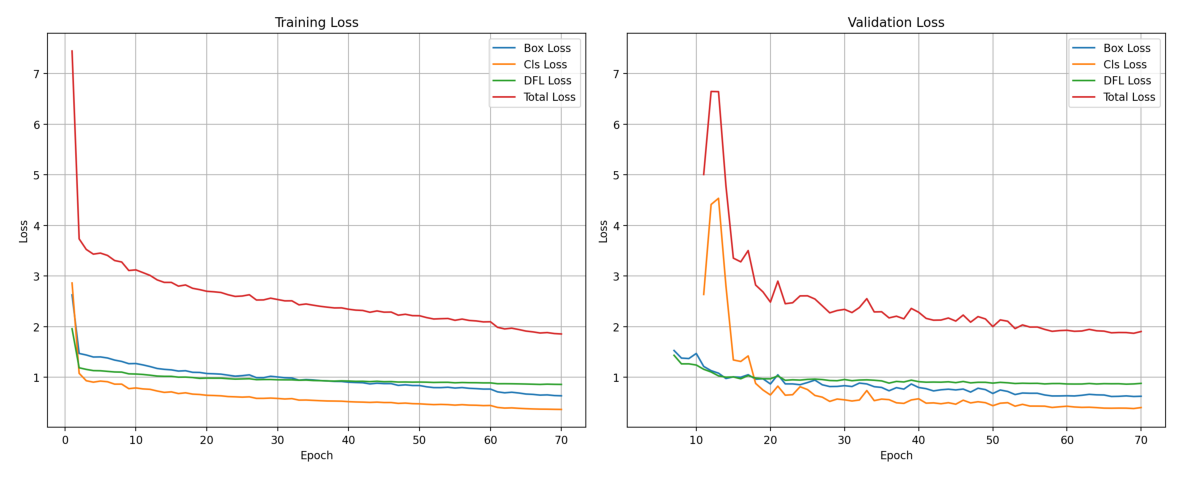

In [3]:
df = pd.read_csv('models/yolo12x/results.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Training loss
ax1.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
ax1.plot(df['epoch'], df['train/cls_loss'], label='Cls Loss')
ax1.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss')
df['train/total_loss'] = df['train/box_loss'] + df['train/cls_loss'] + df['train/dfl_loss']
ax1.plot(df['epoch'], df['train/total_loss'], label='Total Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

# Second subplot: Validation loss
ax2.plot(df['epoch'], df['val/box_loss'], label='Box Loss')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Cls Loss')
ax2.plot(df['epoch'], df['val/dfl_loss'], label='DFL Loss')
df['val/total_loss'] = df['val/box_loss'] + df['val/cls_loss'] + df['val/dfl_loss']
ax2.plot(df['epoch'], df['val/total_loss'], label='Total Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss')
ax2.legend()
ax2.set_ylim(ax1.get_ylim())
ax2.grid(True)

plt.tight_layout()
plt.show()


image 1/1 c:\Users\shard\Desktop\SRIP-Project-Task\split_data\test\images\solarpanels_native_1__x0_3870_y0_11610_dxdy_416.tif: 416x416 19 solar_panels, 124.0ms
Speed: 2.3ms preprocess, 124.0ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\shard\Desktop\SRIP-Project-Task\split_data\test\images\solarpanels_native_1__x0_3061_y0_8047_dxdy_416.tif: 416x416 5 solar_panels, 84.0ms
Speed: 2.5ms preprocess, 84.0ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\shard\Desktop\SRIP-Project-Task\split_data\test\images\solarpanels_native_3__x0_7463_y0_9890_dxdy_416.tif: 416x416 8 solar_panels, 91.4ms
Speed: 1.7ms preprocess, 91.4ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\shard\Desktop\SRIP-Project-Task\split_data\test\images\solarpanels_native_3__x0_8067_y0_10432_dxdy_416.tif: 416x416 2 solar_panels, 69.2ms
Speed: 1.6ms preprocess, 69.2ms inference, 4.6ms postprocess per image a

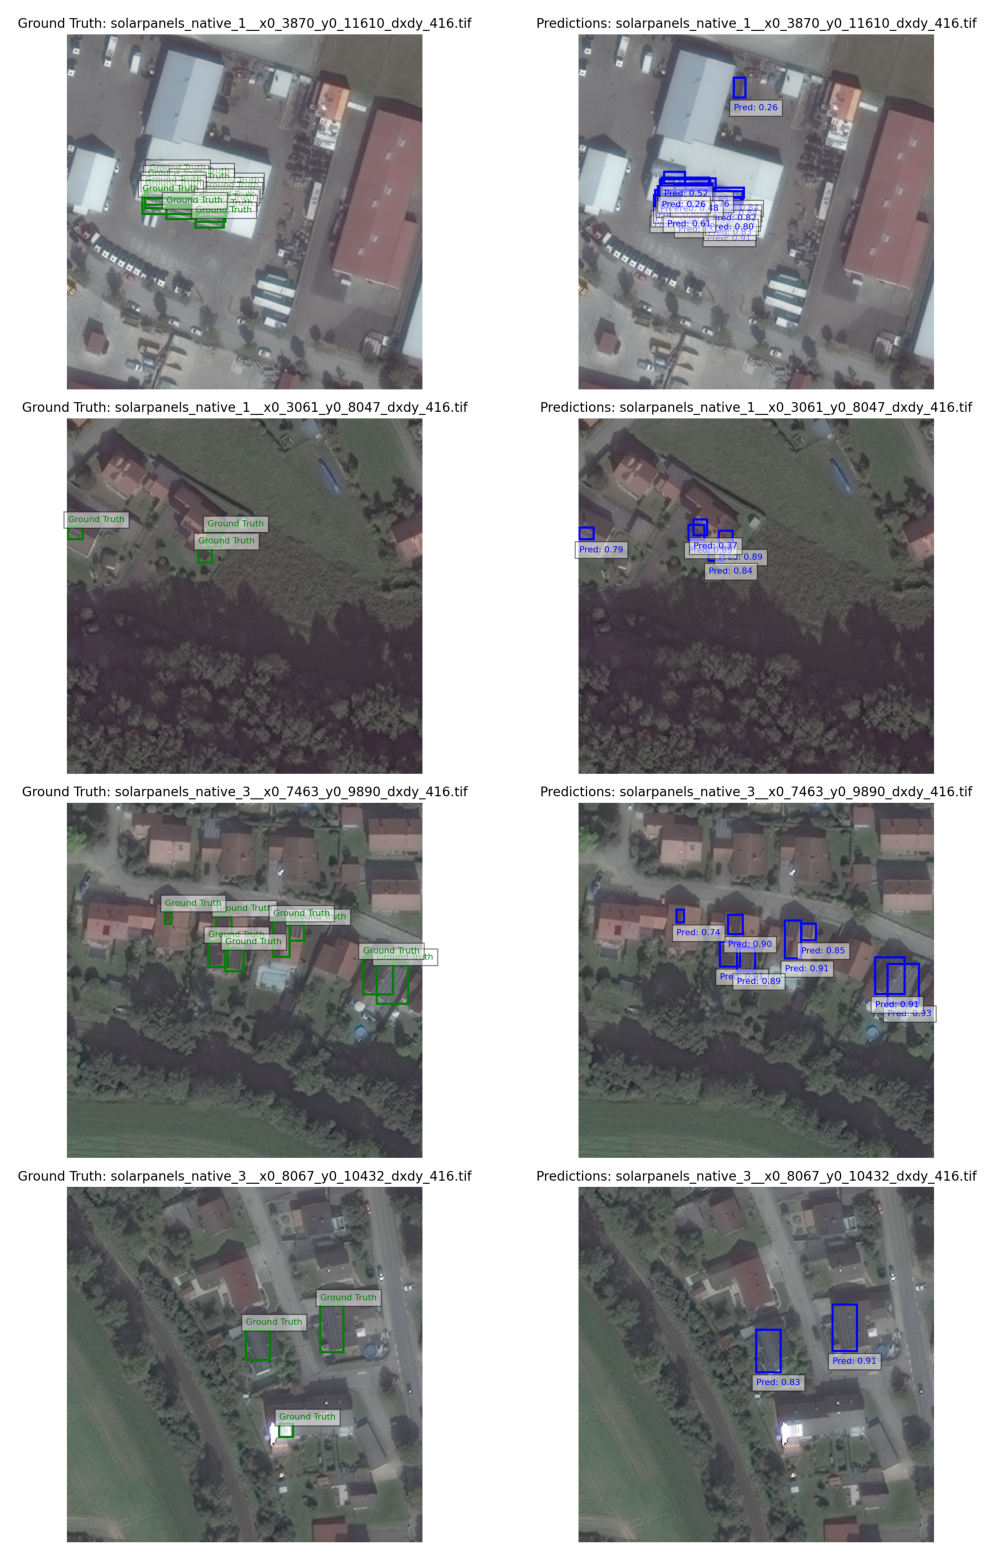

In [8]:
# Load the test data
test_images = os.listdir('split_data/test/images')
test_labels = os.listdir('split_data/test/labels')

# Randomly select 3-4 images
num_images = 4
random_images = np.random.choice(test_images, num_images, replace=False)

fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))

for i, image_name in enumerate(random_images):
    image_path = os.path.join('split_data/test/images', image_name)
    label_path = os.path.join('split_data/test/labels', image_name.replace('.tif', '.txt'))

    # Predict using the trained model
    results = model(image_path)[0]  # Get the first result object

    # Load the image
    image = plt.imread(image_path)

    # Plot the ground truth labels (green)
    with open(label_path, 'r') as f:
        gt_labels = f.readlines()
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Ground Truth: {image_name}")
    for gt_label in gt_labels:
        class_id, x_center, y_center, width, height = map(float, gt_label.split())
        x_min, y_min, x_max, y_max = yolo_to_xyxy([x_center, y_center, width, height], image_size)
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='green', facecolor='none')
        axes[i, 0].add_patch(rect)
        axes[i, 0].text(x_min, y_min - 5, 'Ground Truth', color='green', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

    # Plot the predicted labels (red)
    axes[i, 1].imshow(image)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Predictions: {image_name}")
    boxes = results.boxes
    for box in boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
        conf = float(box.conf[0])
        cls = int(box.cls[0])
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='blue', facecolor='none')
        axes[i, 1].add_patch(rect)
        axes[i, 1].text(x_min, y_max + 15, f'Pred: {conf:.2f}', color='blue', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# save figure
fig.savefig('predictions.png')

### Model Evaluation

In [25]:
def load_detections(image_path):
    label_path = image_path.replace('images', 'labels').replace('.tif', '.txt')
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    xyxy_list = []
    class_ids = []
    scores = []

    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        x_min, y_min, x_max, y_max = yolo_to_xyxy([x_center, y_center, width, height], image_size)
        xyxy_list.append([x_min, y_min, x_max, y_max])
        class_ids.append(class_id)
        scores.append(1.0)

    detections = sv.Detections(
        xyxy=np.array(xyxy_list),
        class_id=np.array(class_ids),
        confidence=np.array(scores),
        metadata={"image_name": os.path.basename(image_path)}
    )

    return detections

In [34]:
# load the ground truth and predictions
test_images = os.listdir('split_data/test/images')
test_labels = os.listdir('split_data/test/labels')

targets = []
predictions = []

for i, image_name in enumerate(test_images):
    image_path = os.path.join('split_data/test/images', image_name)
    label_path = os.path.join('split_data/test/labels', image_name.replace('.tif', '.txt'))

    # Load the ground truth and predictions
    target_sv_detection = load_detections(image_path)
    # print(target_sv_detection.xyxy)

    results = model(image_path, verbose=False)[0] 
    pred_sv_detection = sv.Detections.from_ultralytics(results)
    # print(pred_sv_detection.xyxy)

    targets.append(target_sv_detection)
    predictions.append(pred_sv_detection)

print(len(targets), len(predictions))

509 509


In [35]:
import pickle

# Save the detections
with open("detections.pkl", "wb") as f:
    pickle.dump({"targets": targets, "predictions": predictions}, f)

# Load the detections
with open("detections.pkl", "rb") as f:
    data = pickle.load(f)
targets = data["targets"]
predictions = data["predictions"]

print(len(targets), len(predictions))

509 509


In [32]:
# Compute mAP50 using supervision
metrics = sv.metrics.MeanAveragePrecision()
results = metrics.update(targets, predictions).compute()
mAP50_supervision = results.map50
print(f"mAP50 using supervision: {mAP50_supervision:.4f}")

mAP50 using supervision: 0.9018


In [33]:
# Compute mAP50 using my implementation
all_gt_boxes, all_pred_boxes, all_scores = [], [], []

for target, prediction in zip(targets, predictions):
    all_gt_boxes.append(target.xyxy)
    all_pred_boxes.append(prediction.xyxy)
    all_scores.append(prediction.confidence)

precisions, recalls = compute_precision_recall(all_gt_boxes, all_pred_boxes, all_scores, image_size, iou_threshold=0.5)
mAP50_mine = compute_ap(precisions, recalls, method="auc_pr")

print(f"mAP50 using my implementation: {mAP50_mine:.4f}")

mAP50 using my implementation: 0.8930


**TODO:** 

Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9]

(Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1) 
